In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
%matplotlib inline

data = pd.read_csv("Desktop/Bike-Sharing-Dataset/day.csv")
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


特征casual,registered与cnt都是要预测的y，但因题目要求，所以去掉casual,registered两个特征。

特征中，instant为序号，dteday为日期，无法对cnt造成影响，所以也删掉这两个特征。

In [2]:
data = data.drop(['instant','dteday','casual','registered'],axis=1)
data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


数据初步清理完毕，接下来观察数据的统计特征

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 12 columns):
season        731 non-null int64
yr            731 non-null int64
mnth          731 non-null int64
holiday       731 non-null int64
weekday       731 non-null int64
workingday    731 non-null int64
weathersit    731 non-null int64
temp          731 non-null float64
atemp         731 non-null float64
hum           731 non-null float64
windspeed     731 non-null float64
cnt           731 non-null int64
dtypes: float64(4), int64(8)
memory usage: 68.6 KB


数据中没有缺失值，因此不需要填补缺失值这一步。结合对数据前五行的观察，发现season,yr,mnth,holiday,weekday,workingday,weatherist均为分类特征，而其他包括目标cnt在内的其他特征均为数值型特征。

In [4]:
data.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,4504.348837
std,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,1937.211452
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,3152.000000
50%,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,4548.000000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,5956.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,8714.000000


对于分类特征，统计数据的意义不是特别大，主要看数值型数据。
通过观察可以得出，这几个数值型特征的均值与中位数离的比较近，说明数据不会出现一头重一头轻的情况。cnt的方差很大，而其他特征方差很小，原因是本身
这几个特征的度量单位就很小，最大值也都不超过1，而cnt的值普遍很大。因此据此大胆设想，对cnt做数据处理时可以采用标准化，对其他特征采用归一化。

接下来主要观察单个变量的分布

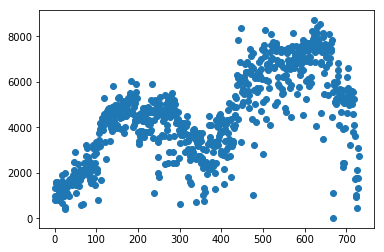

In [5]:
plt.scatter(range(data.shape[0]),data.cnt.values)

这是目标cnt的散点图分布，明显可以看到在[4000,5000]和[6000,8000]的数据很多，说实话，不是特别符合高斯分布的规律，原因暂时存疑。

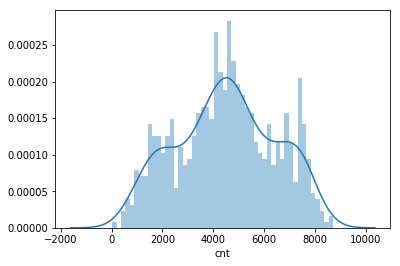

In [6]:
sns.distplot(data.cnt,bins=50)

大体形状还是符合高斯分布的，但在2000和8000左右都各有一个突增点。结合散点图，可以看到0附近和8200的地方有一些离群点，数据处理时可以考虑去掉。

接下来观察数值型特征的分布。

常识判断，温度temp和体感温度atemp的关联性应该是比较强的，因此将两个特征的散点图一起展示：

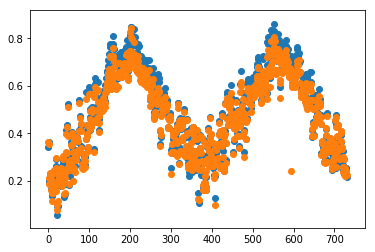

In [7]:
plt.scatter(range(data.shape[0]),data.temp.values)
plt.scatter(range(data.shape[0]),data.atemp.values)

果然，两个特征的分布形状大致相同。其实在计算相关性之前，就可以判定两个特征是冗余的了。

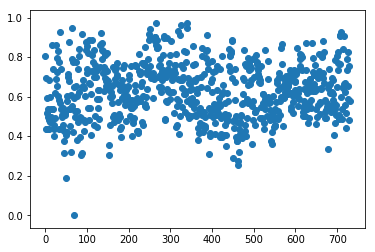

In [8]:
plt.scatter(range(data.shape[0]),data.hum.values)

hum的分布是相对集中且均匀的，有一些离群点需要处理，但在散点图上看不出明显的分布，所以看一看它的直方图

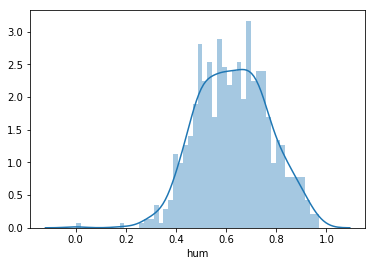

In [9]:
sns.distplot(data.hum,bins=50)

形状有点像高斯分布，但高峰值拉的比较长，和cnt的分布不是特别像

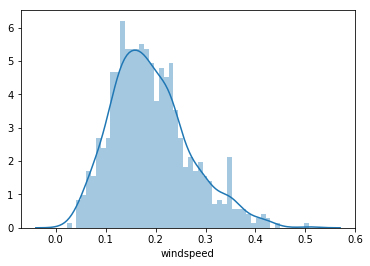

In [10]:
sns.distplot(data.windspeed,bins=50)

形状略微有些左倾，但大体也是符合高斯分布的

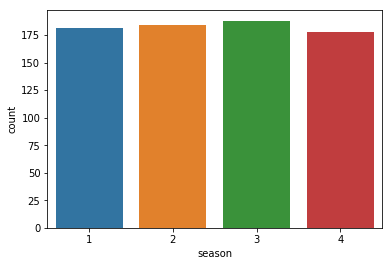

In [11]:
sns.countplot(data.season)

 突然发现观察季节和月份的分布是很无脑的，因为一年四季十二个月，难道会因为骑车人数变化而变化？实际上我认为，对于分类特征，尤其是常识可以判断的东西，关注点应该是它们和目标y之间的关联。所以下一步，直接对特征及目标y之间的相关性做计算与可视化。

首先，对两两特征之间的pearson系数进行计算并给出热图

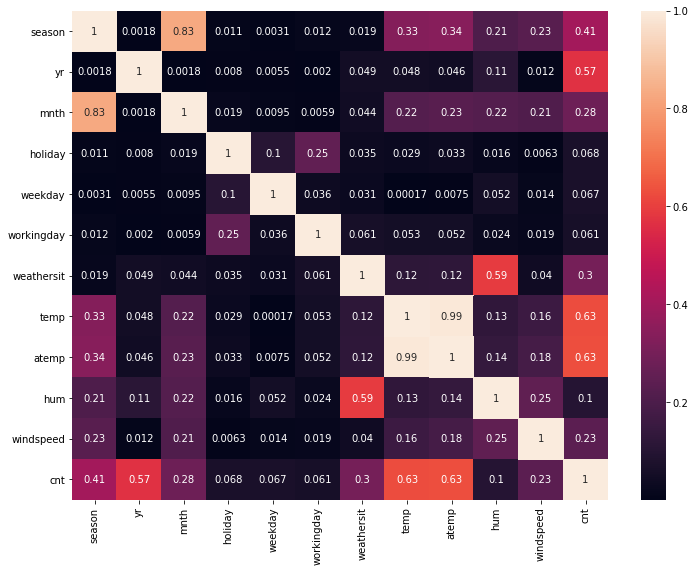

In [12]:
data_corr = data.corr().abs()
plt.subplots(figsize=(12,9))
sns.heatmap(data_corr,annot=True)
sns.heatmap(data_corr,mask=data_corr<1,cbar=False)

单从cnt的角度看，yr,temp,atemp与cnt的相关性是比较高的；从特征的角度看，temp和atemp的相关性已经达到了0.99，和之前的估计一样，是可以删去一个特征的；season和mnth的相关性也比较强，但只有0.83，还没有到直接可以删的地步，等到以后学到pca，或许可以对它进行处理。

接下来看一看几个与cnt相关性强的相关性视图

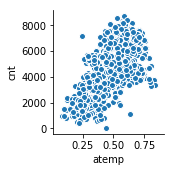

In [13]:
sns.pairplot(data,x_vars='atemp',y_vars='cnt')

看起来还可以，但毕竟相关性也只有0.63，没法完全贴合线性关系。由于temp和atemp相关性太强，所以只展示一个。

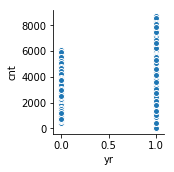

In [14]:
sns.pairplot(data,x_vars='yr',y_vars='cnt')

这时候惊奇地发现，2012年地数据不管从分布广度还是数量来说都比2011要大的多，这也解释了为什么cnt的分布图中会有两个小波峰。即便如此，我还是决定先这样做下去，待会儿再考虑是否将数据分开做数据探索。

数据探索部分基本上完成了，接下来整理一下，实现数据清理代码就可以了

In [15]:
#直观上感受，体感温度比室外温度更能够影响用户的骑车意愿，所以去掉temp特征，保留atemp特征
data = data.drop('temp',axis=1)

#去除cnt离群点
data = data[data.cnt<8000]
data = data[data.cnt>50]

#去除hum离群点
data = data[data.hum>0.3]

数据处理完了，接下来该按题目要求，分离测试数据和训练数据，以及x和y

In [16]:
train = data[data.yr==0].drop('yr',axis=1)
test = data[data.yr==1].drop('yr',axis=1)
x_train = train.drop('cnt',axis=1)
x_test = test.drop('cnt',axis=1)
y_train = train['cnt']
y_test = test['cnt']

接下来进入数据处理阶段

按照上面的分析，要对特征做归一化，对cnt做标准化。这里对分类特征暂时不做特别处理，先把它们和数值型特征一起归一化。

In [17]:
#对特征做归一化
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
#mms_test = MinMaxScaler()
x_train = mms.fit_transform(x_train)
x_test = mms.transform(x_test)

#对cnt做标准化
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
#ss_test = StandardScaler()
y_train = ss.fit_transform(y_train.reshape(-1,1))
y_test = ss.transform(y_test.reshape(-1,1))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  del sys.path[0]


下面用最小二乘线性回归进行拟合

In [18]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

用模型预测训练集和测试集的y，并用r2_score评分

In [19]:
y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)

print("训练集r2_score评分：",r2_score(y_train,y_train_pred))
print("测试集r2_score评分：",r2_score(y_test,y_test_pred))

训练集r2_score评分： 0.7559148011319624
测试集r2_score评分： -0.6798040252290449


这个结果是令人惊讶的，经过分析，发现主要原因是2012年的cnt比2011年的cnt要大的多，显然的，有一些这份数据以外的因素导致cnt的增长，因此，无论如何努力，都无法使得测试集上的r2_score追上训练集上的r2_score。但是，r2_score为负的情况实在让人没有办法接受。有什么方法能够改进吗？我找到了一种不算很正规但我觉得应该没错的方法。

通过观察，发现在做数据标准化的时候，训练数据(尤其是y_test)使用训练数据的StandardScaler来处理的，换句话说，实际上y_test标准化处理时，用的均值和方差都是y_train的均值和方差。这显然和事实是不相符的。即便两者方差的误差是可以接受的，但均值的差距可不是一星半点，毕竟y_test有很大一部分聚集在8000附近。这样就明白了，在做标准化的时候，不能用训练集的标准化模型来处理测试集(仅限于测试集和训练集的误差太大的情况)。那不对y做标准化可以吗？我觉得也不太好。因为即使不做标准化，最后线性拟合的结果也是不好的，因为未知因素的影响实在太大了。经过斟酌，我想如果将测试数据与训练数据分开做标准化是不是会好一些呢？

In [20]:
#对特征做归一化
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
x_train = mms.fit_transform(x_train)
x_test = mms.transform(x_test)

#对y_test和y_train分开做标准化
from sklearn.preprocessing import StandardScaler
ss_train = StandardScaler()
ss_test = StandardScaler()
y_train = ss_train.fit_transform(y_train.reshape(-1,1))
y_test = ss_train.fit_transform(y_test.reshape(-1,1))

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x_train,y_train)

y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)

print("训练集r2_score评分：",r2_score(y_train,y_train_pred))
print("测试集r2_score评分：",r2_score(y_test,y_test_pred))

训练集r2_score评分： 0.7559148011319624
测试集r2_score评分： 0.6882682443144608


果然，结果变为正值了，虽然和训练集上的结果还是有差距，不过总还是迈出了一大步。

其实训练集的结果也不算太好，于是我决定着手处理分类型特征。查来查去，发现好像独热编码用的比较多。大概的作用就是将分类型数值进行扩维，使得分类特征的数据都只用0和1来表示，这样就避免了分类数值较大的样本对结果的影响。比如season特征，原本有1,2,3,4，四个取值，经过独热编码，变成了[1,0,0,0]，[0,1,0,0]，[0,0,1,0]，[0,0,0,1]四种取值。

首先将特征分成数值型特征和分类特征

In [34]:
x_train = train.drop('cnt',axis=1)
x_test = test.drop('cnt',axis=1)
y_train = train['cnt']
y_test = test['cnt']

x_train_type = x_train.drop(['hum','atemp','windspeed'],axis=1)
x_train_num = x_train[['hum','atemp','windspeed']]
x_test_type =  x_test.drop(['hum','atemp','windspeed'],axis=1)
x_test_num = x_test[['hum','atemp','windspeed']]

对数值型数据做归一化

In [35]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
x_train_num = mms.fit_transform(x_train_num)
x_test_num = mms.transform(x_test_num)

对类别型特征做独热编码

In [36]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
x_train_type = enc.fit_transform(x_train_type).toarray()
x_test_type = enc.transform(x_test_type).toarray()

还原特征矩阵

In [40]:
x_train = np.concatenate((x_train_type,x_train_num),axis=1)
x_test = np.concatenate((x_test_type,x_test_num),axis=1)

对cnt做标准化

In [41]:
from sklearn.preprocessing import StandardScaler
ss_y_train = StandardScaler()
ss_y_test = StandardScaler()
y_train = ss_y_train.fit_transform(y_train.reshape(-1,1))
y_test = ss_y_test.fit_transform(y_test.reshape(-1,1))

线性回归

In [42]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x_train,y_train)

y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)

print("训练集r2_score评分：",r2_score(y_train,y_train_pred))
print("测试集r2_score评分：",r2_score(y_test,y_test_pred))

训练集r2_score评分： 0.8370799374588135
测试集r2_score评分： 0.6877896782581587


好吧，这次调优有点失败，但终归还是一种尝试，况且今后的分类特征也要用类似方法来处理，就算是提前熟悉一下吧

接下来用岭回归和Lasso回归尝试一下，看是否有更好的结果

In [52]:
from sklearn.linear_model import RidgeCV

alphas = [0.01,0.1,1,10]
lr = RidgeCV(alphas=alphas,store_cv_values=True)
lr.fit(x_train,y_train)

y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)

print("训练集r2_score评分：",r2_score(y_train,y_train_pred))
print("测试集r2_score评分：",r2_score(y_test,y_test_pred))

训练集r2_score评分： 0.8389856732863064
测试集r2_score评分： 0.6960917881076827


性能好了不少，测试集的评分也略有升高，说明正则项还是起到了一定的作用的。看看结果的可视化。

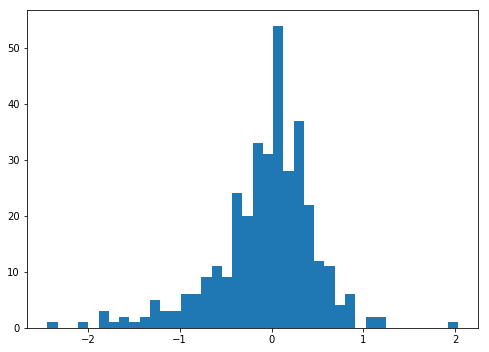

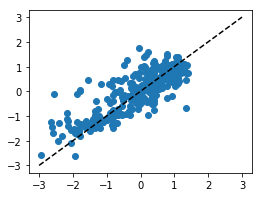

In [53]:
f,ax = plt.subplots(figsize=(7,5))
f.tight_layout()
ax.hist(y_test-y_test_pred,bins=40)

plt.figure(figsize=(4,3))
plt.scatter(y_test,y_test_pred)
plt.plot([-3,3],[-3,3],'--k')

略微有些右倾，负值拉的有些长。具体原因位置，可能是cnt本身差距造成的。

接下来看一看它的正则项是否能调优。

最佳正则参数为： 0.1


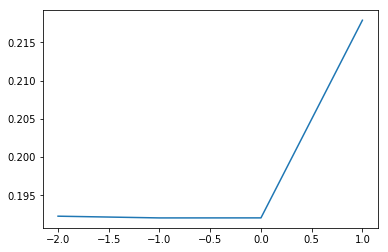

In [54]:
print("最佳正则参数为：",lr.alpha_)
mse_mean = np.mean(lr.cv_values_,axis=0)
plt.plot(np.log10(alphas),mse_mean.reshape(len(alphas),1))

缩小一下参数范围

训练集r2_score评分： 0.8384469697590428
测试集r2_score评分： 0.6938457305343531
最佳正则参数为： 0.5


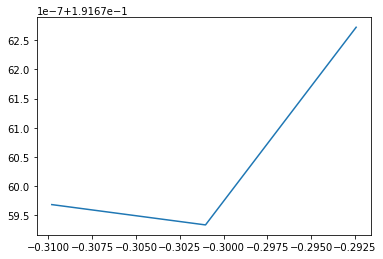

In [67]:
from sklearn.linear_model import RidgeCV

alphas = [0.49,0.5,0.51]
lr = RidgeCV(alphas=alphas,store_cv_values=True)
lr.fit(x_train,y_train)

y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)

print("训练集r2_score评分：",r2_score(y_train,y_train_pred))
print("测试集r2_score评分：",r2_score(y_test,y_test_pred))

print("最佳正则参数为：",lr.alpha_)
mse_mean = np.mean(lr.cv_values_,axis=0)
plt.plot(np.log10(alphas),mse_mean.reshape(len(alphas),1))

经过多次寻找，终于把最佳参数确定到差不多的范围

接下来再用Lasso回归尝试一下

In [68]:
#Lasso回归
from sklearn.linear_model import LassoCV

alphas = [0.01,0.1,1,10,100]
ls =LassoCV(alphas=alphas)
ls.fit(x_train,y_train)

y_train_pred = ls.predict(x_train)
y_test_pred = ls.predict(x_test)

print(r2_score(y_train,y_train_pred))
print(r2_score(y_test,y_test_pred))

0.8097799324474826
0.6968362860350117


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


在这个例子中，Lasso回归要略好于岭回归，但差距不大。Lasso回归参数调优与岭回归差距不大，此处略去过程。

In [ ]:
至此，第一次线性回归的尝试基本完成，有瑕疵或是有疑惑的地方今后修改，欢迎大佬们批评指正!